# Geo Data EDA & Feature Engineering

안녕하세요. 캐글 코리아에서 주최한 2회 대회를 즐겁게 하고 있는 사람으로서 제가 사용하고 있는 Feature Engineering을 공유하려고 합니다.

집값을 결정하는데 가장 중요한 요소는 입지라는 것은 모두 잘 아실거라고 생각합니다. 그래서 저는 기본 데이터에 대한 Feature Engineering 외에 위치에 관련된 Feature Engineering에 가장 시간을 쏟고 있는데요.

기본 데이터에 대한 EDA 및 Feature Engineering은 다른 분들이 공개한 좋은 커널이 많이 있으므로 생략하고, 위치에 관련된 zipcode, lat, long 데이터의 Feature Engineering에 집중해서 살펴보겠습니다.

보시고 도움이 됐다면 제 Kernel에 Vote 해주시면 감사하겠습니다! 

* [Baseline Model](#Baseline-Model)
* Geo Data Feature Engineering
  * [Zipcode Feature Engineering](#Zipcode-Feature-Engineering)
  * [PCA Transformation - Lat, Long](#PCA-Transformation---Lat,-Long)
  * [K-Means Clustering - Lat, Long](#K-Means-Clustering---Lat,-Long)
    * [Determine K by Elbow method](#Determine-K-by-Elbow-method)
    * [Determine K by CV Score](#Determine-K-by-CV-Score)
  * [Haversine Distance](#Haversine-Distance)
* [Conclusion](#Conclusion)

기본적인 코드는 아래의 커널들을 많이 참고했습니다.
* https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12
* https://www.kaggle.com/yeonmin/default-eda-stacking-introduction

위도(Lat), 경도(Long) 데이터를 기반으로한 Feature Engineering은 아래 글을 참고했습니다.

[Good Feature Building Techniques — Tricks for Kaggle — My Kaggle Code Repository](https://becominghuman.ai/good-feature-building-techniques-tricks-for-kaggle-my-kaggle-code-repository-c953b934f1e6)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import xgboost as xgb
import lightgbm as lgb

# Set a few plotting defaults
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
def rmse_exp(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

def train_test_split(data, do_ohe=True):
    df = data.drop(['id','price','data'], axis=1).copy()
    cat_cols = df.select_dtypes('object').columns
    for col in cat_cols:
        if do_ohe:
            ohe_df = pd.get_dummies(df[[col]], prefix='ohe_'+col)
            df.drop(col, axis=1, inplace=True)
            df = pd.concat([df, ohe_df], axis=1)
        else:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    train_len = data[data['data'] == 'train'].shape[0]
    X_train = df.iloc[:train_len]
    X_test = df.iloc[train_len:]
    y_train = data[data['data'] == 'train']['price']
    
    return X_train, X_test, y_train

def get_oof_lgb(X_train, y_train, X_test, lgb_param, verbose_eval=False, return_cv_score_only=False):

    folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    oof = np.zeros(len(X_train))
    predictions = np.zeros(len(X_test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        if verbose_eval > 0: print(f'Fold : {fold_ + 1}')
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

        num_round = 100000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=verbose_eval, early_stopping_rounds=200)
        oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
        predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
        
        cv_fold_score = rmse_exp(y_train.iloc[val_idx], oof[val_idx])
        
        if verbose_eval > 0: print(f'Fold {fold_ + 1} / CV-Score: {cv_fold_score:.6f}')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns.tolist()
        fold_importance_df['importance'] = clf.feature_importance('gain')
        fold_importance_df['fold'] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    cv_score = rmse_exp(y_train, oof)
    print(f'CV-Score: {cv_score:.6f}')
    if return_cv_score_only: return cv_score
    else: return oof, predictions, cv_score, feature_importance_df
    
def plot_feature_importance(fi_df, num_feature=20):
    cols = (fi_df[['feature', 'importance']]
            .groupby('feature')
            .mean()
            .sort_values(by='importance', ascending=False)[:num_feature].index)
    best_features = fi_df.loc[fi_df.feature.isin(cols)]

    sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
    plt.title('Feature Importances (averaged over folds)')
    plt.tight_layout()
    plt.show()
    
def plot_numeric_for_regression(df, field, target_field='price'):
    df = df[df[field].notnull()]

    fig = plt.figure(figsize = (16, 7))
    ax1 = plt.subplot(121)
    
    sns.distplot(df[df['data'] == 'train'][field], label='Train', hist_kws={'alpha': 0.5}, ax=ax1)
    sns.distplot(df[df['data'] == 'test'][field], label='Test', hist_kws={'alpha': 0.5}, ax=ax1)

    plt.xlabel(field)
    plt.ylabel('Density')
    plt.legend()
    
    ax2 = plt.subplot(122)
    
    df_copy = df[df['data'] == 'train'].copy()

    sns.scatterplot(x=field, y=target_field, data=df_copy, ax=ax2)
    
    plt.show()
    
def plot_categorical_for_regression(df, field, target_field='price', show_missing=True, missing_value='NA'):
    df_copy = df.copy()
    if show_missing: df_copy[field] = df_copy[field].fillna(missing_value)
    df_copy = df_copy[df_copy[field].notnull()]

    ax1_param = 121
    ax2_param = 122
    fig_size = (16, 7)
    if df_copy[field].nunique() > 30:
        ax1_param = 211
        ax2_param = 212
        fig_size = (16, 10)
    
    fig = plt.figure(figsize = fig_size)
    ax1 = plt.subplot(ax1_param)
    
    sns.countplot(x=field, hue='data', order=np.sort(df_copy[field].unique()), data=df_copy)
    plt.xticks(rotation=90, fontsize=11)
    
    ax2 = plt.subplot(ax2_param)
    
    df_copy = df_copy[df_copy['data'] == 'train']

    sns.boxplot(x=field, y=target_field, data=df_copy, order=np.sort(df_copy[field].unique()), ax=ax2)
    plt.xticks(rotation=90, fontsize=11)
    
    plt.show()
    
def load_original_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')

    train_copy = train.copy()
    train_copy['data'] = 'train'
    test_copy = test.copy()
    test_copy['data'] = 'test'
    test_copy['price'] = np.nan

    # remove outlier
    train_copy = train_copy[~((train_copy['sqft_living'] > 12000) & (train_copy['price'] < 3000000))].reset_index(drop=True)

    # concat train, test data to preprocess
    data = pd.concat([train_copy, test_copy], sort=False).reset_index(drop=True)
    data = data[train_copy.columns]

    data.drop('date', axis=1, inplace=True)
    data['zipcode'] = data['zipcode'].astype(str)

    # fix skew feature
    skew_columns = ['price']

    for c in skew_columns:
        data[c] = np.log1p(data[c])
        
    return data

In [5]:
data = load_original_data()

print(data.shape)
data.head()

(21502, 21)


id      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  12.309987         3       1.00         1180      5650     1.0   
1   1  12.100718         2       1.00          770     10000     1.0   
2   2  13.142168         3       2.00         1680      8080     1.0   
3   3  12.458779         3       2.25         1715      6819     2.0   
4   4  12.583999         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated zipcode      lat     long  sqft_living15  sqft_lot15   data  
0             0   98178  47.5112 -122.257           1340        5650  train  
1             0   98028  47.7379 -122.233           2720        8062  train  
2             0   98074  47.6168 -122.045           1800        7503  train  
3             0   98003  47.3097 -122.327           2238        6819  train  
4             0   98198  47.4095 -122.315           1650        9711  train

## Baseline Model

LightGBM 5-Fold Out Of Fold Prediction을 Baseline model로 사용하겠습니다.

기본 데이터의 Baseline model CV 스코어는 아래와 같습니다. Categorical 데이터는 One Hot Encoding으로 처리하겠습니다.

In [6]:
X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 87) (6468, 87)
CV-Score: 117117.035579


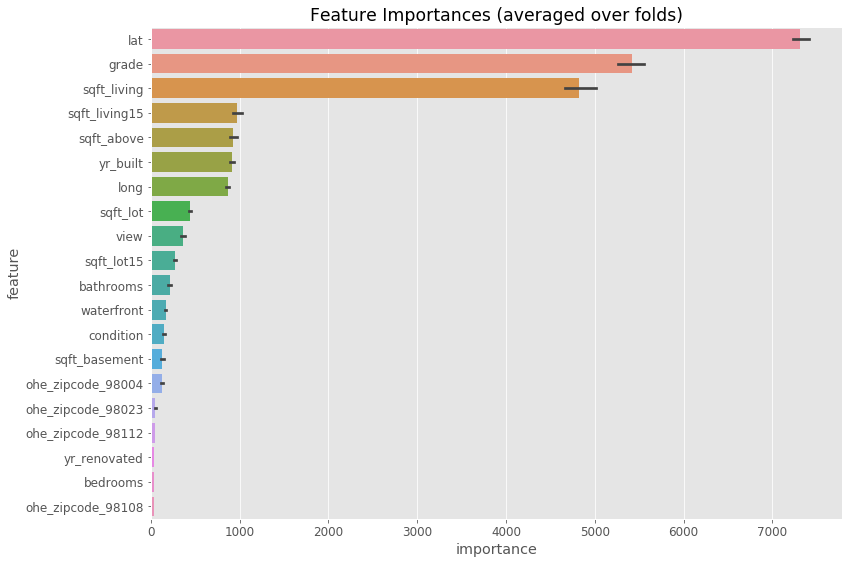

In [7]:
plot_feature_importance(fi_df)

Feature Importance를 보면 zipcode의 98004, 98023, 98112, 98108이 중요한 feature로 나오는데요.

zipcode와 price의 boxplot을 그려보면 98004, 98112는 집값이 비싼 지역 98023, 98108은 집값이 낮은 지역임을 알 수 있습니다.

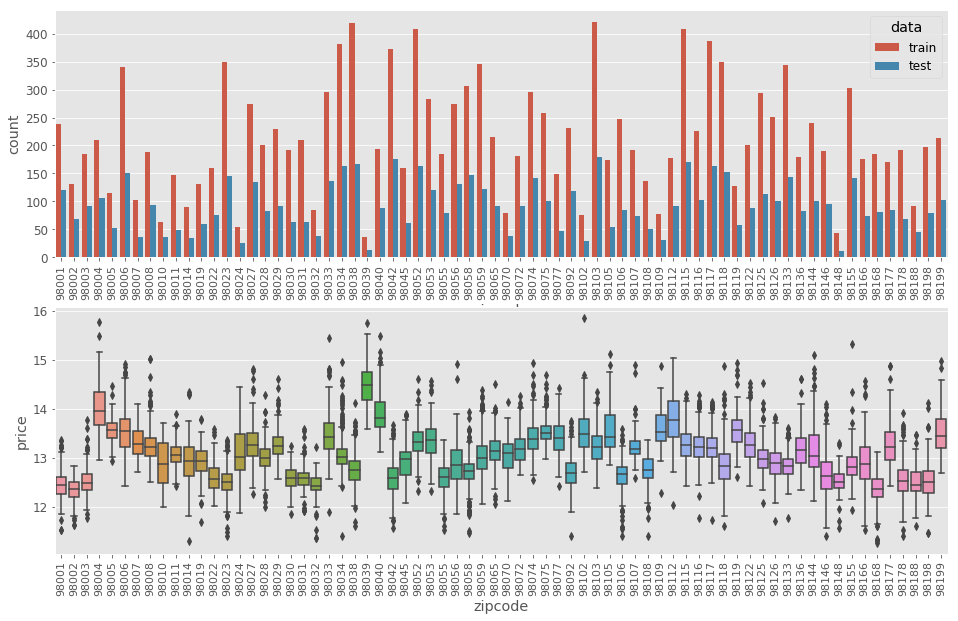

In [8]:
plot_categorical_for_regression(data, 'zipcode')

98004, 98112, 98023, 98108 지역이 어느 위치에 있는지 위도, 경도 데이터를 통해 확인해보겠습니다.

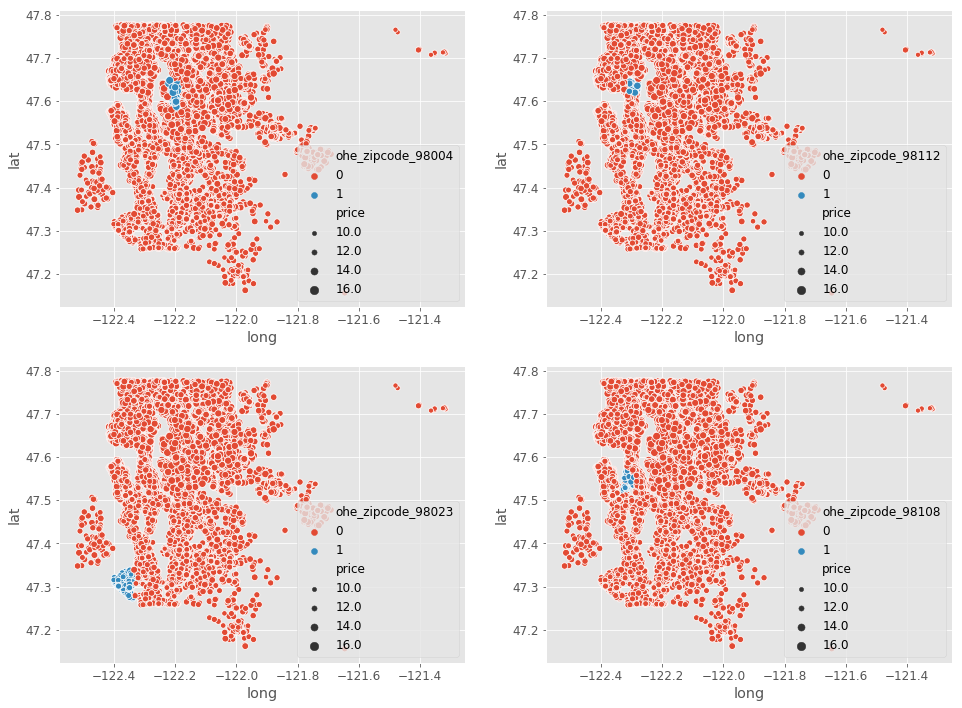

In [9]:
df = X_train
df['price'] = y_train

fig = plt.figure(figsize = (16, 12))

ax1 = plt.subplot(221)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98004', size='price', data=df, ax=ax1)

ax2 = plt.subplot(222)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98112', size='price', data=df, ax=ax2)

ax3 = plt.subplot(223)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98023', size='price', data=df, ax=ax3)

ax4 = plt.subplot(224)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98108', size='price', data=df, ax=ax4)

plt.show()

## Zipcode Feature Engineering

Zipcode는 다섯자리로 된 숫자형의 데이터인데, 데이터를 보면 앞의 두 자리는 98로 동일합니다.

그래서 뒤의 세 자리의 숫자를 여러가지 방법으로 쪼개서 새로운 feature를 만들어보겠습니다.  

In [10]:
data = load_original_data()

data['zipcode-3'] = 'z_' + data['zipcode'].str[2:3]
data['zipcode-4'] = 'z_' + data['zipcode'].str[3:4]
data['zipcode-5'] = 'z_' + data['zipcode'].str[4:5]
data['zipcode-34'] = 'z_' + data['zipcode'].str[2:4]
data['zipcode-45'] = 'z_' + data['zipcode'].str[3:5]
data['zipcode-35'] = 'z_' + data['zipcode'].str[2:3] + data['zipcode'].str[4:5]

print(data.shape)
data.head()

(21502, 27)


id      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  12.309987         3       1.00         1180      5650     1.0   
1   1  12.100718         2       1.00          770     10000     1.0   
2   2  13.142168         3       2.00         1680      8080     1.0   
3   3  12.458779         3       2.25         1715      6819     2.0   
4   4  12.583999         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated zipcode      lat     long  sqft_living15  sqft_lot15   data  \
0             0   98178  47.5112 -122.257           1340        5650  train   
1             0   98028  47.7379 -122.233           2720        8062  train   
2             0   98074  47.6168 -122.045           1800        7503  train   
3             0   98003  47.3097 -122.327           2238        6819  train   
4             0   98198  47.4095 -122.315           1650        9711  train   

  zipcode-3 zipcode-4 zipcode-5 zipcode-34 zipcode-45 zipcode-35  
0       z_1       z_7       z_8       z_17       z_78       z_18  
1       z_0       z_2       z_8       z_02       z_28       z_08  
2       z_0       z_7       z_4       z_07       z_74       z_04  
3       z_0       z_0       z_3       z_00       z_03       z_03  
4       z_1       z_9       z_8       z_19       z_98       z_18

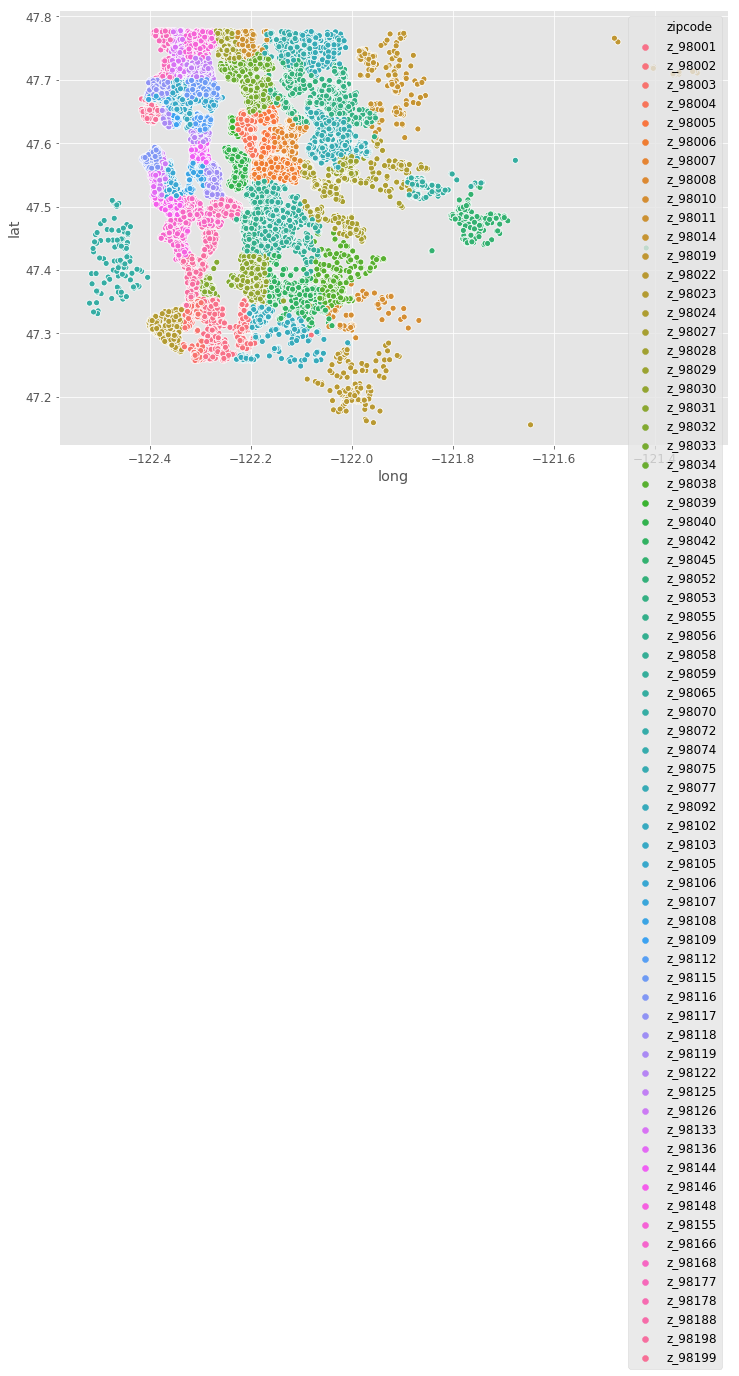

In [11]:
data['zipcode'] = 'z_' + data['zipcode']
sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(data['zipcode'].unique()), data=data);

새롭게 만든 zipcode feature를 지도에서 살펴보겠습니다.

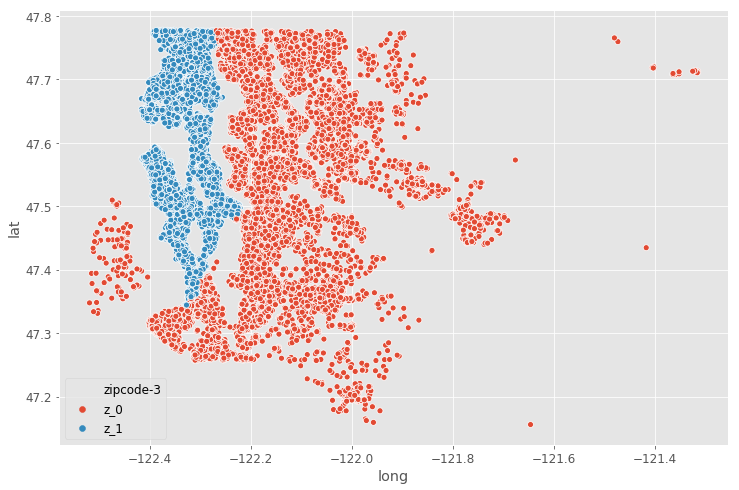

In [12]:
sns.scatterplot(x='long', y='lat', hue='zipcode-3', hue_order=np.sort(data['zipcode-3'].unique()), data=data);

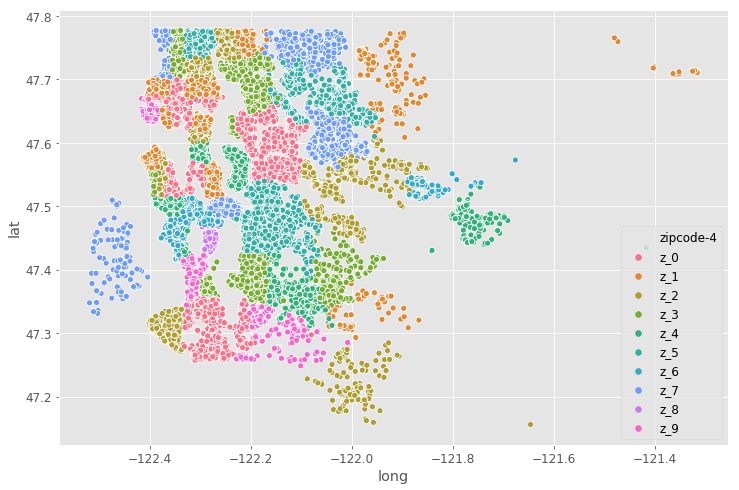

In [13]:
sns.scatterplot(x='long', y='lat', hue='zipcode-4', hue_order=np.sort(data['zipcode-4'].unique()), data=data);

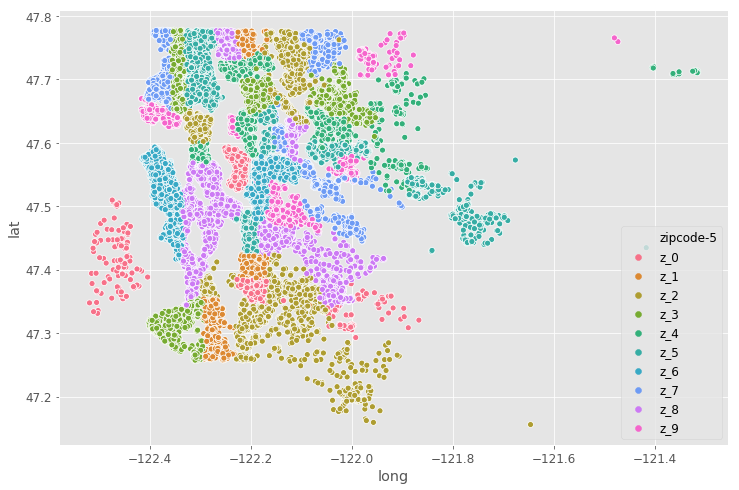

In [14]:
sns.scatterplot(x='long', y='lat', hue='zipcode-5', hue_order=np.sort(data['zipcode-5'].unique()), data=data);

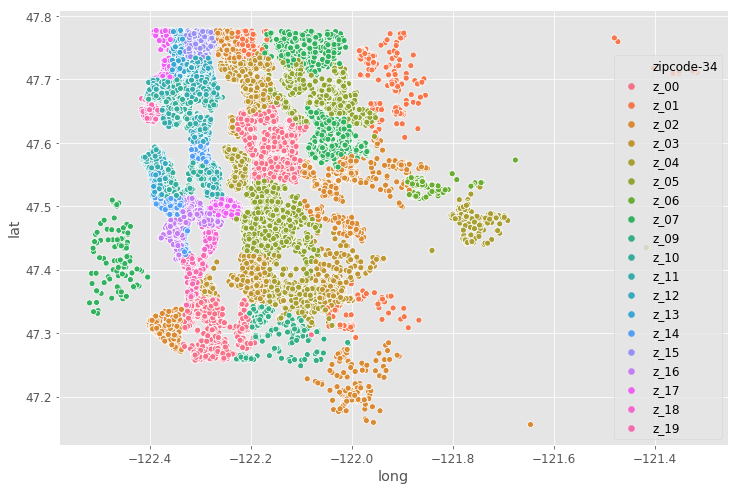

In [15]:
sns.scatterplot(x='long', y='lat', hue='zipcode-34', hue_order=np.sort(data['zipcode-34'].unique()), data=data);

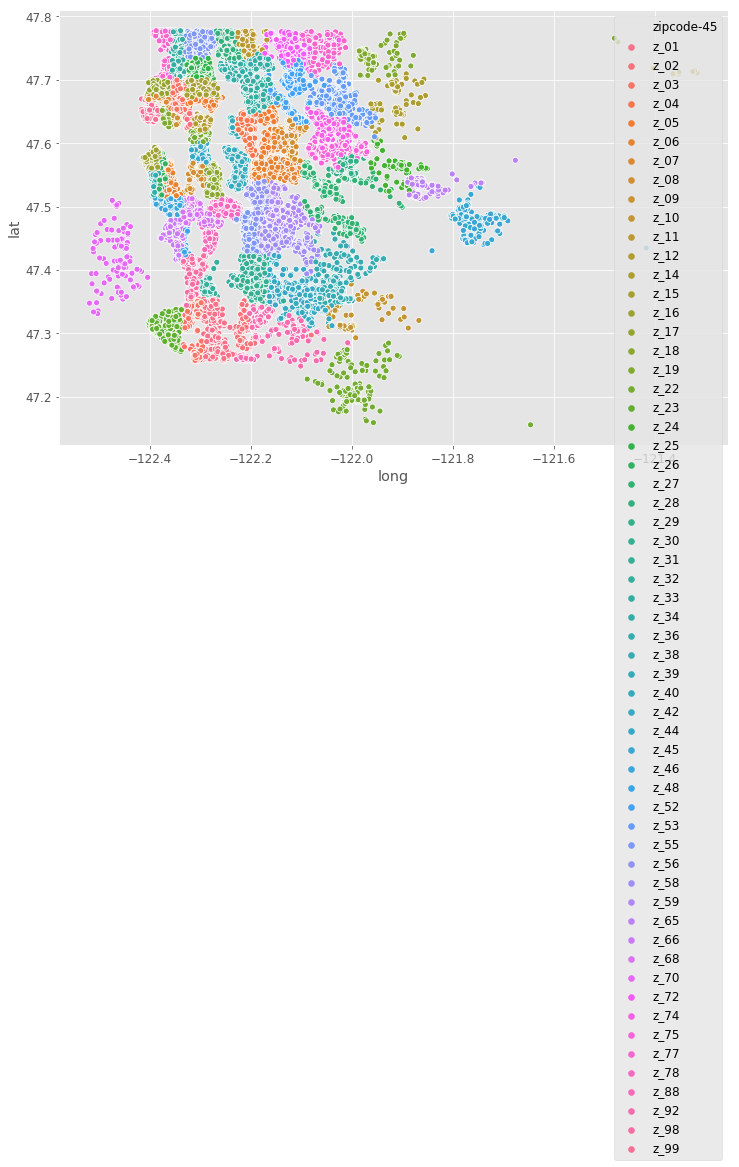

In [16]:
sns.scatterplot(x='long', y='lat', hue='zipcode-45', hue_order=np.sort(data['zipcode-45'].unique()), data=data);

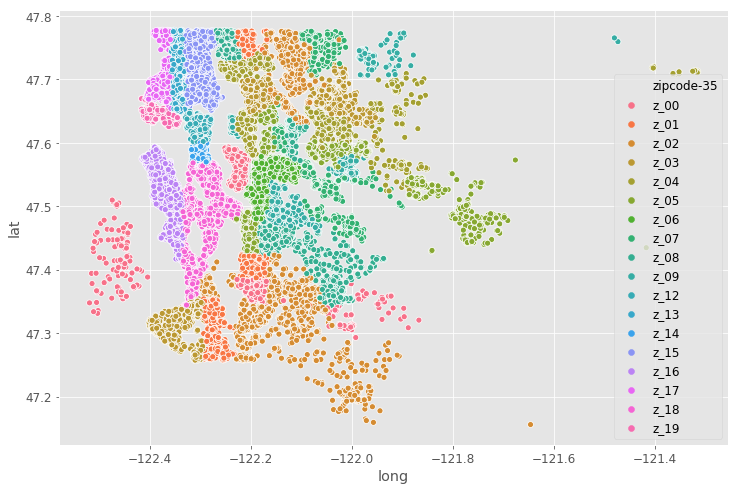

In [17]:
sns.scatterplot(x='long', y='lat', hue='zipcode-35', hue_order=np.sort(data['zipcode-35'].unique()), data=data);

In [18]:
X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 205) (6468, 205)
CV-Score: 116084.904360


새롭게 만든 zipcode feature로 CV Score가 더 좋아진 것을 확인할 수 있습니다.

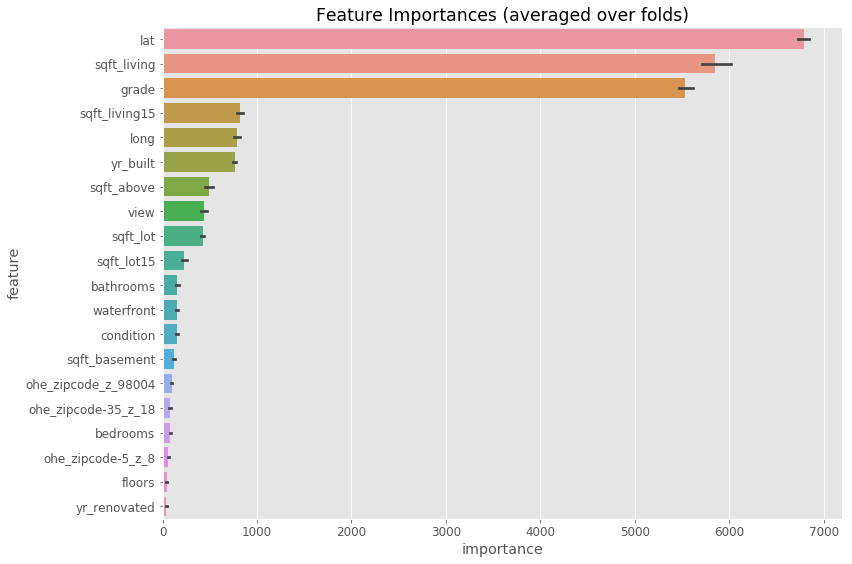

In [19]:
plot_feature_importance(fi_df)

Feature Importance를 보면 zipcode-35의 18, zipcode-5의 8이 중요한 feature로 나오고 boxplot을 그려보면 집값이 싼 지역임을 알 수 있습니다.

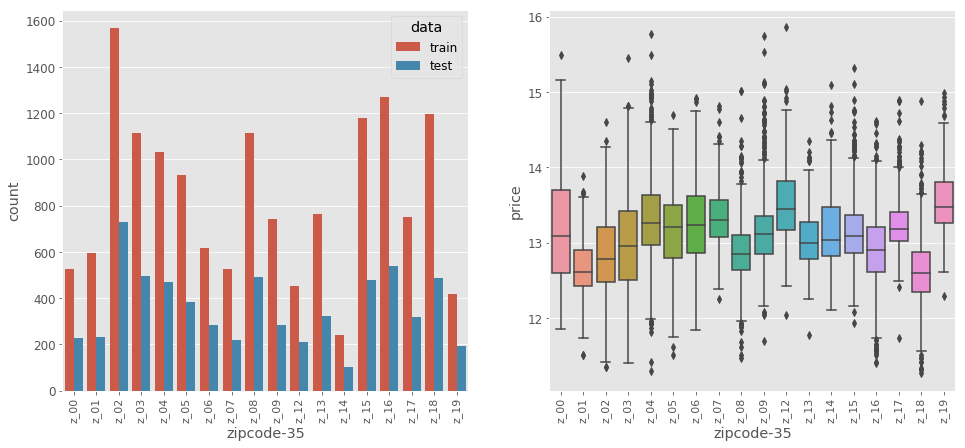

In [20]:
plot_categorical_for_regression(data, 'zipcode-35')

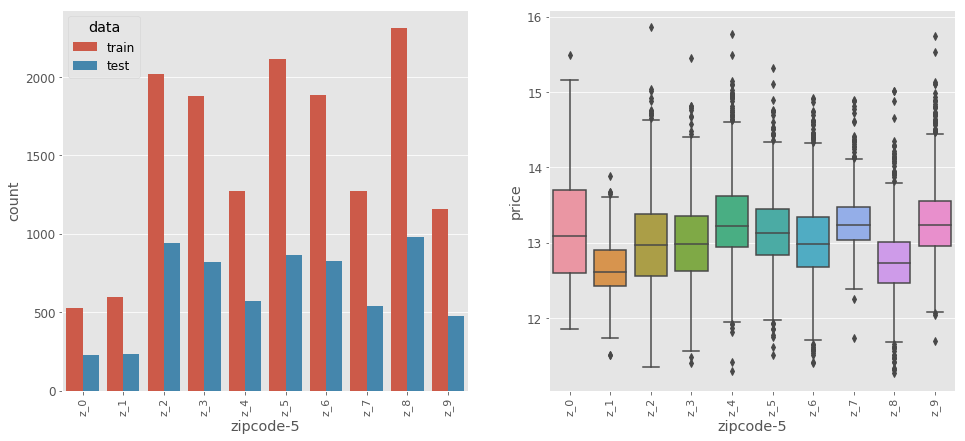

In [21]:
plot_categorical_for_regression(data, 'zipcode-5')

## PCA Transformation - Lat, Long

PCA는 차원축소에 주로 사용되는 알고리즘입니다. 위도, 경도의 데이터만 보면 2차원의 데이터인데, 이 데이터를 차원축소는 하지 않고 2차원 그대로 PCA Transformation을 하면 원본 데이터를 변형해서 새로운 feature를 만들 수 있습니다.

In [22]:
# pca for lat, long
data = load_original_data()

coord = data[['lat','long']]
pca = PCA(n_components=2)
pca.fit(coord)

coord_pca = pca.transform(coord)

data['coord_pca1'] = coord_pca[:, 0]
data['coord_pca2'] = coord_pca[:, 1]

이렇게 만들어진 feature를 2차원에 그려보면 원본 데이터가 변형되서 새로운 feature로 만들어진 것을 확인할 수 있습니다.

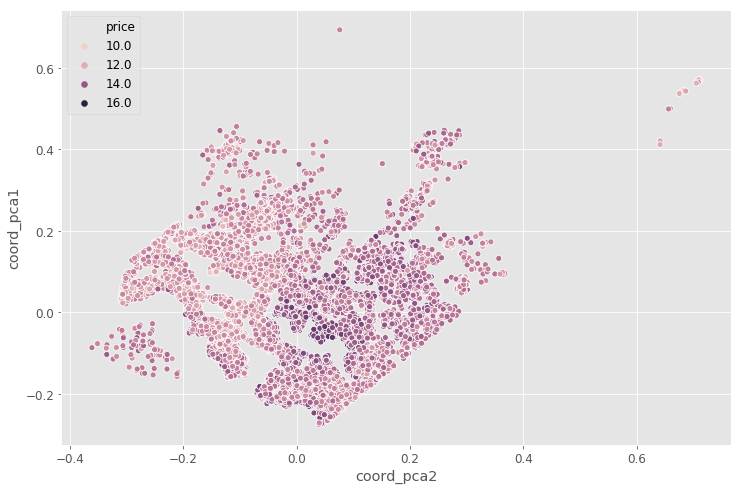

In [23]:
sns.scatterplot(x='coord_pca2', y='coord_pca1', hue='price', data=data);

In [24]:
X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 89) (6468, 89)
CV-Score: 116045.627563


PCA를 통해 만든 feature로 CV Score가 더 좋아진 것을 확인할 수 있고, 아래 feature importance에서도 중요한 feature로 나오는 것을 알 수 있습니다.

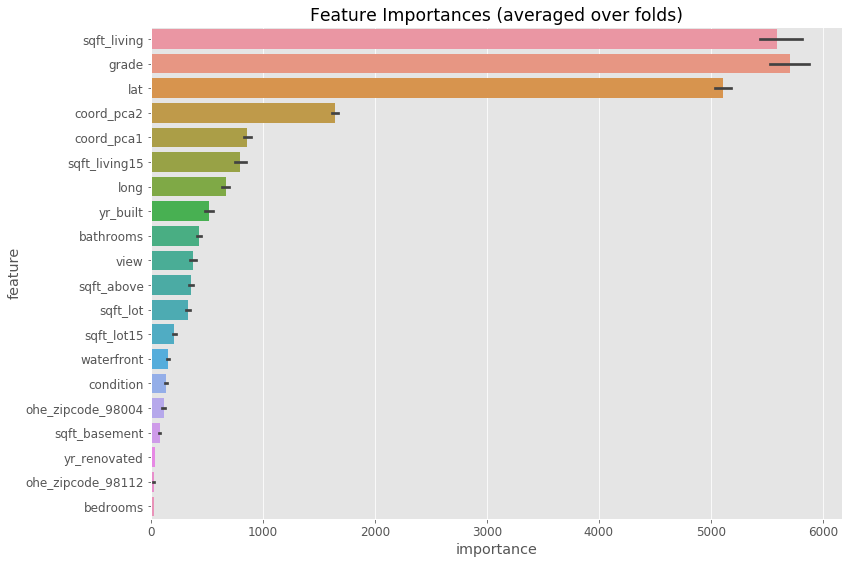

In [25]:
plot_feature_importance(fi_df)

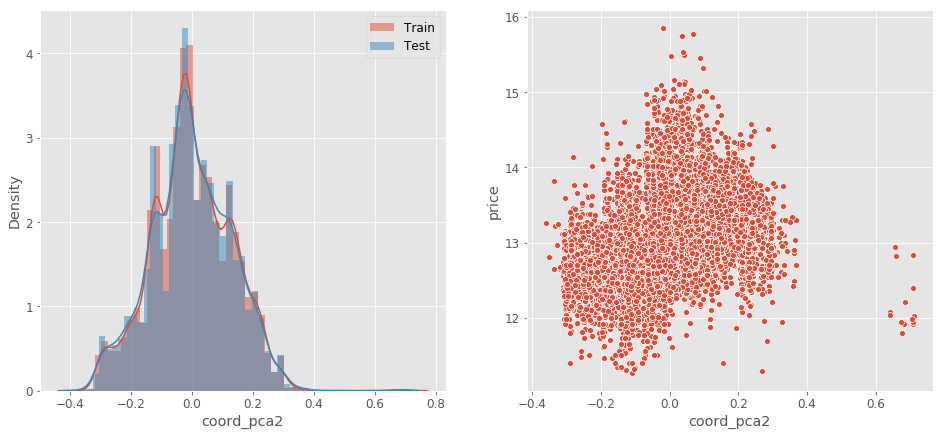

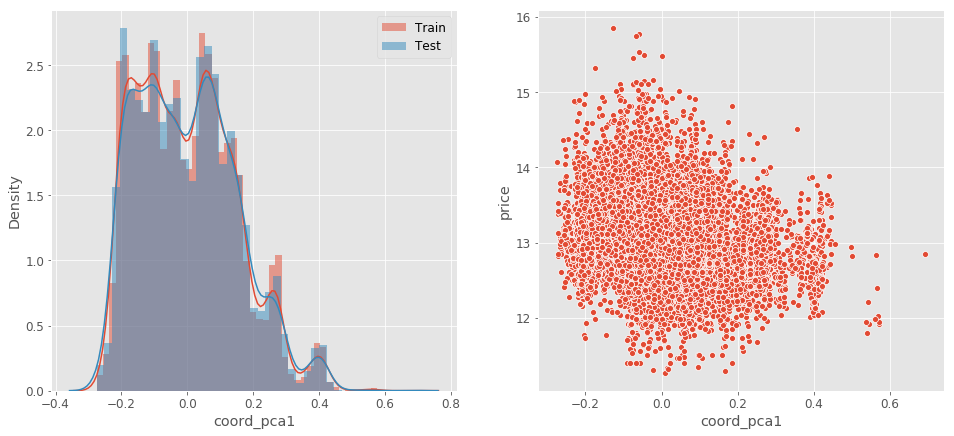

In [26]:
plot_numeric_for_regression(data, 'coord_pca2')
plot_numeric_for_regression(data, 'coord_pca1')

## K-Means Clustering - Lat, Long

K-Means Clustering은 Clustering에 사용되는 비지도학습 알고리즘 중의 하나입니다. 위도, 경도 데이터를 K-Means Clustering 하면 가까운 지역끼리 Cluster가 만들어지기 때문에 zipcode와 유사한 개념의 새로운 feature를 만들 수 있습니다.

### Determine K by Elbow method

K-Means Clustering에서 중요한 건 K 값을 어떻게 결정하느냐 인데요. 일반적으로 많이 쓰이는 방법은 K 값을 늘려가면서 여러 개 돌려보면, Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데 이 지점의 K 값을 많이 사용합니다. 이런 방식을 Elbow Method라고 합니다. 먼저 Elbow Method를 통해 K 값을 결정해보겠습니다.

k: 2  cost: 506.98113400801344
k: 3  cost: 311.7459990927527
k: 4  cost: 246.30288082273648
k: 5  cost: 198.64041461037152
k: 6  cost: 157.44913426070576
k: 7  cost: 130.41658927639352
k: 8  cost: 107.04097248127474
k: 9  cost: 94.7047068957774
k: 10  cost: 86.20648228339098
k: 11  cost: 77.87311958386205
k: 12  cost: 70.78331278730434
k: 13  cost: 64.62897121771768
k: 14  cost: 59.68860120663161
k: 15  cost: 54.92440624403009


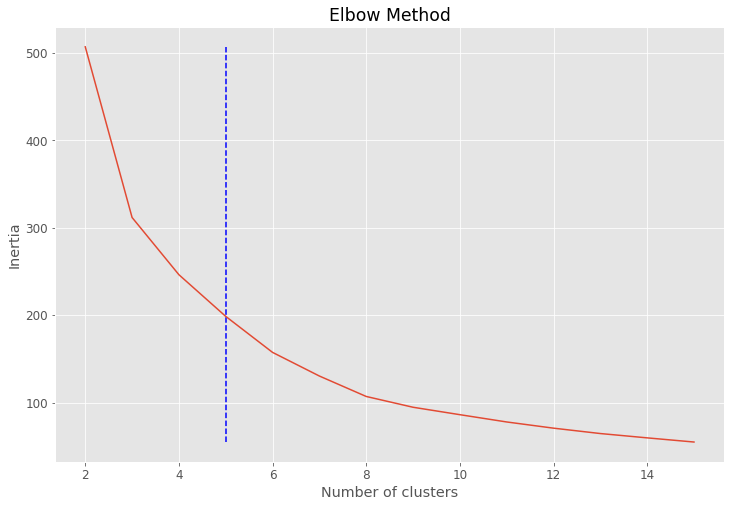

In [27]:
inertia_arr = []

k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED).fit(coord)
 
    # Sum of distances of samples to their closest cluster center
    interia = kmeans.inertia_
    print ("k:",k, " cost:", interia)
    inertia_arr.append(interia)
    
inertia_arr = np.array(inertia_arr)

plt.plot(k_range, inertia_arr)
plt.vlines(5, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

위의 그래프를 보면 5가 가장 적절한 K 값으로 볼 수 있습니다.

In [28]:
data = load_original_data()

# kmeans for lat, long
kmeans = KMeans(n_clusters=5, random_state=RANDOM_SEED).fit(coord)
coord_cluster = kmeans.predict(coord)
data['coord_cluster'] = coord_cluster
data['coord_cluster'] = data['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))

X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 92) (6468, 92)
CV-Score: 116602.052357


### Determine K by CV Score

또, 다른 방식으로 K 값을 결정해볼 수 도 있는데요. K-Means Clustering으로 만든 feature를 Regression Model에서 결국 사용하기 때문에 K 값도 하나의 하이퍼 파라미터로 보고 CV Score가 가장 낮게 나오는 K를 선택해서 사용할 수도 있습니다.

In [29]:
k_range = range(2, 80, 5)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED).fit(coord)
    coord_cluster = kmeans.predict(coord)
    data['coord_cluster'] = coord_cluster
    data['coord_cluster'] = data['coord_cluster'].map(lambda x: str(x).rjust(2, '0'))
    
    X_train, X_test, y_train = train_test_split(data)

    lgb_param = {
        'objective': 'regression',
        'learning_rate': 0.05,
        'num_leaves': 15,
        'bagging_fraction': 0.7,
        'bagging_freq': 1,
        'feature_fraction': 0.7,
        'seed': RANDOM_SEED,
        'metric': ['rmse'],
    }

    print('K :', k)
    get_oof_lgb(X_train, y_train, X_test, lgb_param)
    print()

K : 2
CV-Score: 115902.721493

K : 7
CV-Score: 117012.821948

K : 12
CV-Score: 117633.381409

K : 17
CV-Score: 117980.012678

K : 22
CV-Score: 115394.302373

K : 27
CV-Score: 116387.329731

K : 32
CV-Score: 114912.070556

K : 37
CV-Score: 116293.213373

K : 42
CV-Score: 116896.247402

K : 47
CV-Score: 117466.252997

K : 52
CV-Score: 117855.937920

K : 57
CV-Score: 117774.707390

K : 62
CV-Score: 117242.539181

K : 67
CV-Score: 118321.452717

K : 72
CV-Score: 117634.792546

K : 77
CV-Score: 117457.471212



In [30]:
k_range = range(28, 37)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED).fit(coord)
    coord_cluster = kmeans.predict(coord)
    data['coord_cluster'] = coord_cluster
    data['coord_cluster'] = data['coord_cluster'].map(lambda x: str(x).rjust(2, '0'))
    
    X_train, X_test, y_train = train_test_split(data)

    lgb_param = {
        'objective': 'regression',
        'learning_rate': 0.05,
        'num_leaves': 15,
        'bagging_fraction': 0.7,
        'bagging_freq': 1,
        'feature_fraction': 0.7,
        'seed': RANDOM_SEED,
        'metric': ['rmse'],
    }

    print('K :', k)
    get_oof_lgb(X_train, y_train, X_test, lgb_param)
    print()

K : 28
CV-Score: 116885.453464

K : 29
CV-Score: 117193.354172

K : 30
CV-Score: 116309.474791

K : 31
CV-Score: 116837.138863

K : 32
CV-Score: 114912.070556

K : 33
CV-Score: 115573.155910

K : 34
CV-Score: 116697.662762

K : 35
CV-Score: 115208.925945

K : 36
CV-Score: 116782.564807



K 값이 32일 때 CV Score가 가장 좋게 나오는 것을 알 수 있습니다. Elbow Method로 K 값을 선택했을 때보다 CV Score 기준으로 K를 선택할 때가 더 모델 성능이 좋기 때문에 최종 K 값은 32로 사용하겠습니다.  

In [31]:
# kmeans for lat, long
kmeans = KMeans(n_clusters=32, random_state=RANDOM_SEED).fit(coord)
coord_cluster = kmeans.predict(coord)
data['coord_cluster'] = coord_cluster
data['coord_cluster'] = data['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))

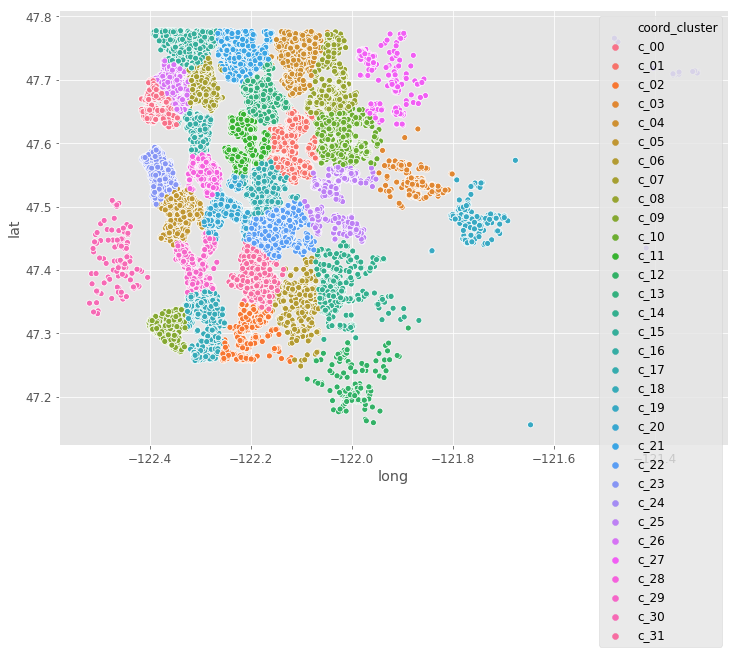

In [32]:
sns.scatterplot(x='long', y='lat', hue='coord_cluster', hue_order=np.sort(data['coord_cluster'].unique()), data=data);

In [33]:
X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 119) (6468, 119)
CV-Score: 114912.070556


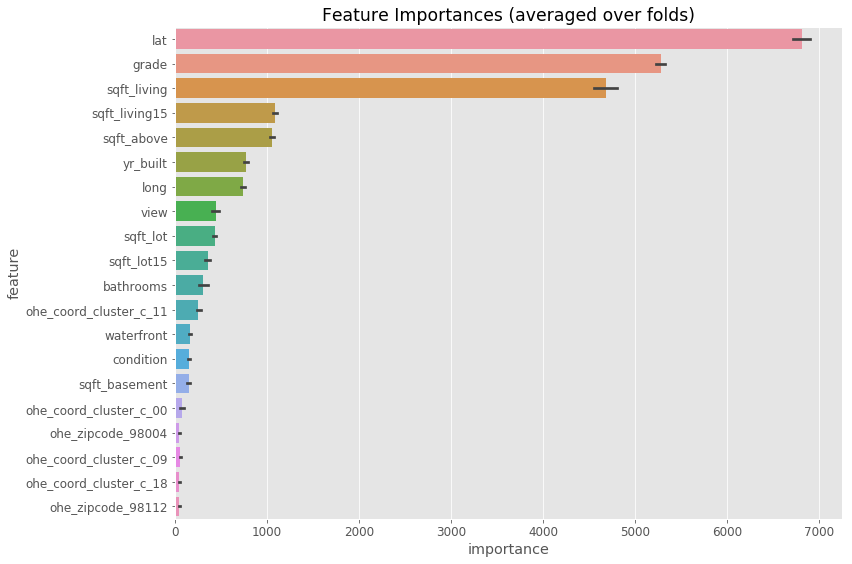

In [34]:
plot_feature_importance(fi_df)

Feature Importance를 보면 11번 cluster가 중요한 feature임을 알 수 있습니다. 아래 그래프에서 11번 cluster의 위치를 확인해볼 수 있습니다.

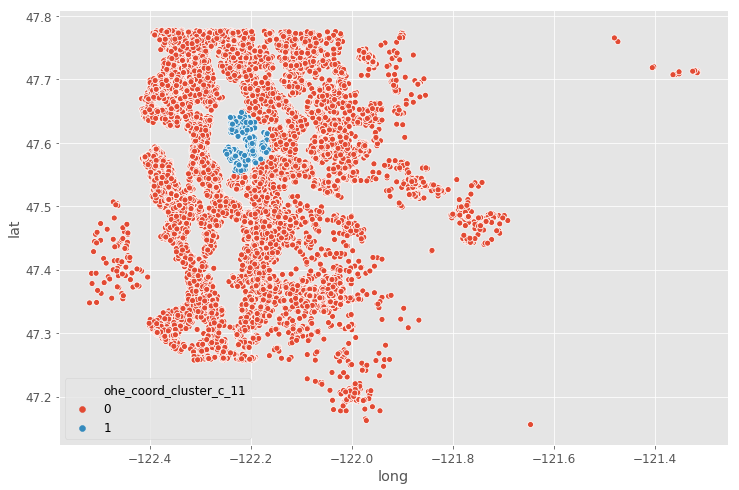

In [35]:
df = X_train
df['price'] = y_train
sns.scatterplot(x='long', y='lat', hue='ohe_coord_cluster_c_11', data=df);

Cluster의 boxplot을 확인해보면 11번 cluster가 집값이 가장 비싼 지역임을 알 수 있습니다.

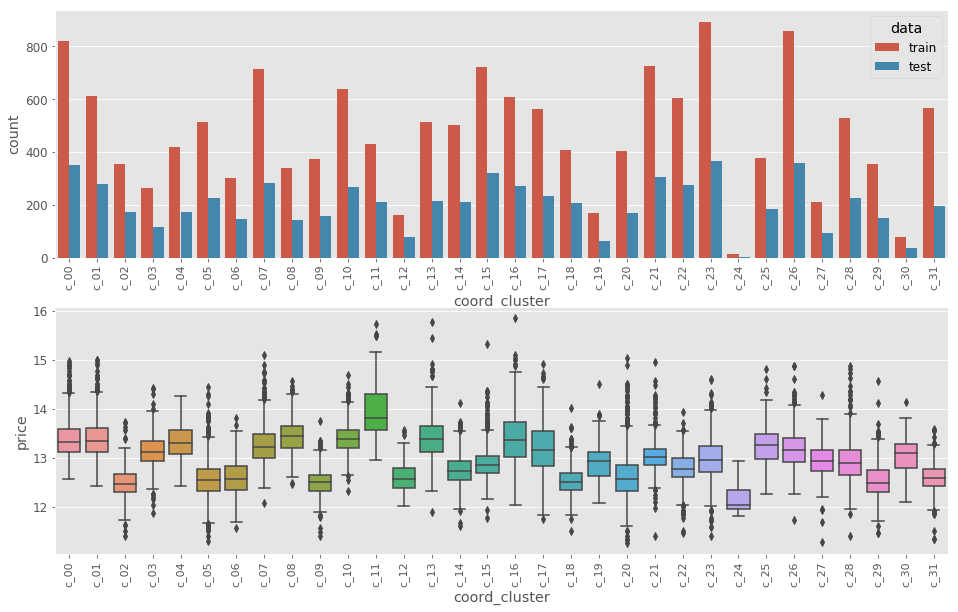

In [36]:
plot_categorical_for_regression(data, 'coord_cluster')

## [Haversine Distance](https://en.wikipedia.org/wiki/Haversine_formula)

마지막으로 Haversine Distance를 사용한 feature 생성입니다. Haversine Distance는 두 개의 위도, 경도 좌표에서 지구의 곡률을 고려해 두 좌표 간의 거리를 구하는 방법입니다.

아래의 function으로 Haversine Distance를 구할 수 있습니다.

In [37]:
def haversine_array(lat1, lng1, lat2, lng2): 
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2)) 
    AVG_EARTH_RADIUS = 6371 # in km 
    lat = lat2 - lat1 
    lng = lng2 - lng1 
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2 
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)) 
    return h

주어진 데이터에서 위도, 경도의 최소값과, 최대값 두 개의 좌표에 대해 거리를 구해보면 113.88km가 나오는데, 가장 먼 거리의 거리가 이 정도라는 얘기가 되겠네요.

In [38]:
print(data['lat'].min(), data['lat'].max(), data['long'].min(), data['long'].max())

haversine_dist = haversine_array(data['lat'].min(), data['long'].min(), data['lat'].max(), data['long'].max())
print(f'max distance: {haversine_dist:.2f}km')

47.1559 47.7776 -122.519 -121.315
max distance: 113.88km


아래는 id가 0인 집과 전체 집과의 거리를 구한 데이터입니다. 0번 집과 가까운 이웃은 집값이 비슷할 확률이 높기 때문에 거리를 기반으로 가까운 이웃집의 데이터를 찾을 수 있습니다. 이런 식으로 전체 집들의 Haversine Distance를 구하면 나와 가까운 이웃집들의 정보를 새로운 feature로 활용할 수 있습니다.

In [39]:
neighbor_df = pd.DataFrame()
lat2 = data['lat'].values
long2 = data['long'].values

lat1 = data.loc[0, 'lat'] # id = 0 house lat
long1 = data.loc[0, 'long'] # id = 0 house long
dist_arr = haversine_array(lat1, long1, lat2, long2)
neighbor_df = pd.DataFrame({
    'id': np.tile(np.array([data.loc[0, 'id']]), data.shape[0]),
    'neighbor_id': data['id'],
    'neighbor_lat': lat2,
    'neighbor_long': long2,
    'distance': dist_arr,
})
    
print(neighbor_df.shape)
neighbor_df.head()

(21502, 5)


id  neighbor_id  neighbor_lat  neighbor_long   distance
0   0            0       47.5112       -122.257   0.000000
1   0            1       47.7379       -122.233  25.271977
2   0            2       47.6168       -122.045  19.771055
3   0            3       47.3097       -122.327  23.016635
4   0            4       47.4095       -122.315  12.120049

아래는 0번 집의 반경 5km 이내의 이웃들을 그려본 그래프입니다. 

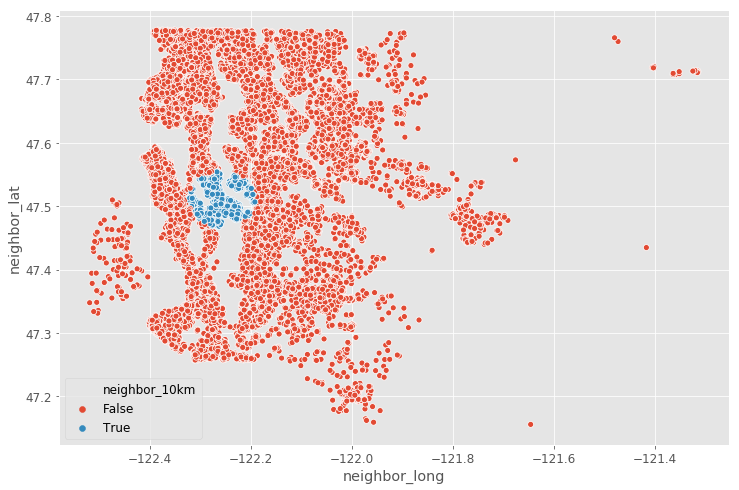

In [40]:
neighbor_df['neighbor_10km'] = neighbor_df['distance'] <= 5
sns.scatterplot(x='neighbor_long', y='neighbor_lat', hue='neighbor_10km', data=neighbor_df);

## Conclusion

지금까지 위치 데이터를 활용한 Feature Engineering을 살펴봤습니다. 특히, 마지막의 Haversine Distance를 활용하면 각 집에서 가까운 이웃집을 계산할 수 있고, 이를 바탕으로 다양한 feature를 만들어 낼 수 있습니다.

저같은 경우 이러한 Geo Data Feature Engineering과 Stacking Ensemble을 통해 퍼블릭 리더보드 기준으로 RMSE 스코어가 96000대까지 성능이 나오는 모델을 만들 수 있었습니다. 제가 공유한 내용이 다른 분들에게도 도움이 됐으면 좋겠네요.

감사합니다.